#### Instantiating the VGG16 convolutional base

In [1]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

Using TensorFlow backend.
W0924 11:46:07.068485 4561331648 deprecation_wrapper.py:119] From /anaconda3/envs/keras-tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0924 11:46:07.098326 4561331648 deprecation_wrapper.py:119] From /anaconda3/envs/keras-tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0924 11:46:07.100772 4561331648 deprecation_wrapper.py:119] From /anaconda3/envs/keras-tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0924 11:46:07.131417 4561331648 deprecation_wrapper.py:119] From /anaconda3/envs/keras-tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

#### Extracting features using the pretrained convolutional base

In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/ferborges@br.ibm.com/Downloads/train/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [3]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

#### Defining and training the densely connected classifier

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

W0924 11:56:18.622045 4561331648 deprecation.py:506] From /anaconda3/envs/keras-tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(optimizer=RMSprop(lr=2e-5),
                loss='binary_crossentropy',
                metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

W0924 11:56:18.677541 4561331648 deprecation_wrapper.py:119] From /anaconda3/envs/keras-tensorflow/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0924 11:56:18.689692 4561331648 deprecation.py:323] From /anaconda3/envs/keras-tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.6097 - acc: 0.6630 - val_loss: 0.4566 - val_acc: 0.8080
Epoch 2/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.4394 - acc: 0.7985 - val_loss: 0.3671 - val_acc: 0.8520
Epoch 3/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.3581 - acc: 0.8485 - val_loss: 0.3247 - val_acc: 0.8740
Epoch 4/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.3215 - acc: 0.8670 - val_loss: 0.3012 - val_acc: 0.8830
Epoch 5/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.2878 - acc: 0.8860 - val_loss: 0.3000 - val_acc: 0.8690
Epoch 6/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.2705 - acc: 0.8885 - val_loss: 0.2759 - val_acc: 0.8850
Epoch 7/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.2441 - acc: 0.9065 - val_loss: 0.2639 - val_acc: 0.8970
Epoch 8/30
200

#### Plotting the results

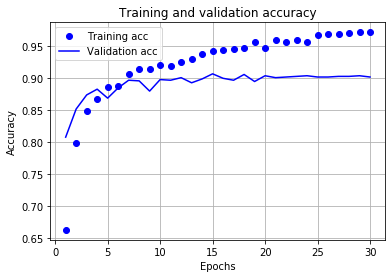

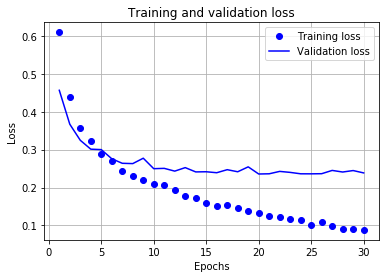

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()